<a href="https://colab.research.google.com/github/Ldunda/datamining/blob/main/combine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# 1) Importing Libraries and Packages

In [3]:
# Gerekli kütüphanelerin yüklenmesi
import numpy as np
import pandas as pd
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,roc_auc_score, confusion_matrix

In [4]:
# Loading the Spacy Model
nlp = spacy.load('en_core_web_sm')

# 2) Loading and Preprocessing Dataset with Text Cleaning and TF-IDF Vectorization

In [5]:
def get_dataset(tf_idf_type="original"):
    # Define column names for the datasets
    column_names = ['Review', 'Sentiment']

    # Load labeled datasets from files
    data_amazon = pd.read_csv('amazon_cells_labelled.txt', sep='\t', header=None, names=column_names)
    data_imdb = pd.read_csv('imdb_labelled.txt', sep='\t', header=None, names=column_names)
    data_yelp = pd.read_csv('yelp_labelled.txt', sep='\t', header=None, names=column_names)

    # Concatenate the datasets into one
    data = pd.concat([data_amazon, data_imdb, data_yelp], ignore_index=True)

    # Function to clean text by removing punctuation and stopwords
    def clean_text(sentence):
        sentence = sentence.lower()
        sentence = "".join([char for char in sentence if char not in string.punctuation])
        tokens = sentence.split()
        cleaned_tokens = [token for token in tokens if token not in STOP_WORDS]
        return " ".join(cleaned_tokens)

    # Apply text cleaning to the 'Review' column
    data['Cleaned_Review'] = data['Review'].apply(clean_text)

    # Split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(data['Cleaned_Review'], data['Sentiment'], test_size=0.2, random_state=13)

    # Apply different TF-IDF vectorization strategies based on the input argument
    if tf_idf_type == "original":
        tfidf_vectorizer = TfidfVectorizer()

    elif tf_idf_type == "unigram":
        tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

    elif tf_idf_type == "bigram":
        # Bigram
        tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2))

    else:
        # Unigram + Bigram
        tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

    # Transform the training and testing data using TF-IDF
    x_train_vector = tfidf_vectorizer.fit_transform(x_train)
    x_test_vector = tfidf_vectorizer.fit(x_train).transform(x_test)


    return x_train_vector, x_test_vector, y_train, y_test

# 3) Feature Selection

In [6]:
def select_features(x_train_vector, x_test_vector, y_train, y_test, feature_selection_method="", k=1000):
    # Chi-Square Feature Selection
    if feature_selection_method == "chi2":
        chi2_selector = SelectKBest(chi2, k=k).fit(x_train_vector, y_train)
        x_train = chi2_selector.transform(x_train_vector)
        x_test = chi2_selector.transform(x_test_vector)

        return x_train, x_test, y_train, y_test
    # Principal Component Analysis (PCA) for Feature Selection
    elif feature_selection_method == "pca":
        pca = PCA(n_components=k).fit(x_train_vector, y_train)  # Reduce to k components
        x_train = pca.transform(x_train_vector)
        x_test = pca.transform(x_test_vector)

        return x_train, x_test, y_train, y_test
    # Lasso Regression for Feature Selection (L1 Regularization)
    elif feature_selection_method == "lasso":
        lasso = LogisticRegression(penalty='l1', solver='liblinear')
        lasso.fit(x_train_vector, y_train)

        # Feature Selection based on the model
        sfm = SelectFromModel(lasso, threshold="mean")  # Features above the mean importance are selected
        x_train = sfm.transform(x_train_vector)
        x_test = sfm.transform(x_test_vector)

        return x_train, x_test, y_train, y_test
    # Singular Value Decomposition (SVD) for Dimensionality Reduction
    elif feature_selection_method == "svd":
        svd = TruncatedSVD(n_components=k).fit(x_train_vector, y_train)
        x_train = svd.transform(x_train_vector)
        x_test = svd.transform(x_test_vector)

        return x_train, x_test, y_train, y_test
    # No Feature Selection applied
    else:
        return x_train_vector, x_test_vector, y_train, y_test

# 4) Model Training and Evaluation

In [7]:
def train_model(x_train, x_test, y_train, y_test, classifier_type="rfc"):
    # Random Forest Classifier
    if classifier_type == "random_forest_classifier":
        clf_model = RandomForestClassifier(random_state=13)
        clf_model.fit(x_train, y_train)
    # Logistic Regression
    elif classifier_type == "logistic_regression":
        clf_model = LogisticRegression(random_state=13)
        clf_model.fit(x_train, y_train)
    # Support Vector Machine with RBF kernel
    elif classifier_type == "support_vector_machine":
        clf_model = SVC(kernel="rbf", gamma=1, C=10) ## v0
        clf_model.fit(x_train, y_train)
    # Decision Tree Classifier
    elif classifier_type == "decision_tree":
        clf_model = DecisionTreeClassifier(random_state=42) ## v0
        clf_model.fit(x_train, y_train)

    # elif classifier_type == "naive_bayes":
    #     if fea
    #     gnb = GaussianNB()
    #     gnb.fit(x_train.toarray(), y_train)

    #     y_pred = gnb.predict(x_test.toarray())

    #     results = classification_report(y_pred, y_test, output_dict=True)

    #     f1_score = results["weighted avg"]["f1-score"] * 100

    #     return f1_score

    else:
        print("Not implemented model error!!")
        assert False
    # Make predictions using the trained model
    y_pred = clf_model.predict(x_test)

    # Generate classification report
    results = classification_report(y_pred, y_test, output_dict=True)

    # Calculate F1 score
    f1_score = results["weighted avg"]["f1-score"] * 100

    return f1_score

In [8]:
# Dataset Loading and Shape Checking
x_train_vector, x_test_vector, y_train, y_test = get_dataset()

print("Eğitim Verisi Boyutu:", x_train_vector.shape)
print("Test Verisi Boyutu:", x_test_vector.shape)

Eğitim Verisi Boyutu: (2198, 4542)
Test Verisi Boyutu: (550, 4542)


# 5) Model Evaluation with Different TF-IDF, Feature Selection, and Classification Techniques

In [9]:
results = []
k = 1000

# for k in [100, 500, 1500, 2000]:
for tf_idf_type in ["original", "unigram", "bigram", "unigram+bigram"]:
    x_train_vector, x_test_vector, y_train, y_test = get_dataset(tf_idf_type)

    print("Eğitim Verisi Boyutu:", x_train_vector.shape)
    print("Test Verisi Boyutu:", x_test_vector.shape)

    for feature_selection_method in ["chi2","pca","lasso","svd",""]:
        x_train, x_test, y_train, y_test = select_features(x_train_vector, x_test_vector, y_train, y_test, feature_selection_method, k=1000)

        for classification_model in ["random_forest_classifier", "logistic_regression", "support_vector_machine", "decision_tree"]:
            f1_score = train_model(x_train, x_test, y_train, y_test, classification_model)
            print(tf_idf_type, feature_selection_method, classification_model, f1_score)

            results.append(" ".join([tf_idf_type, feature_selection_method, classification_model, str(f1_score)]))


        with open("results_" + str(k) + ".txt", "w") as f:
            f.write("\n".join(results))


Eğitim Verisi Boyutu: (2198, 4542)
Test Verisi Boyutu: (550, 4542)
original chi2 random_forest_classifier 75.71519142630014
original chi2 logistic_regression 78.55964405964406
original chi2 support_vector_machine 77.63717686219248
original chi2 decision_tree 76.18772400423777
original pca random_forest_classifier 71.31226666955416
original pca logistic_regression 78.54375227660427
original pca support_vector_machine 75.90616809800025
original pca decision_tree 64.36175144013924
original lasso random_forest_classifier 73.44242621578249
original lasso logistic_regression 74.7815184988232
original lasso support_vector_machine 74.36931455435392
original lasso decision_tree 71.2918568671164
original svd random_forest_classifier 73.57288685123737
original svd logistic_regression 79.27108270790582
original svd support_vector_machine 75.08100596821303
original svd decision_tree 63.64790520524757
original  random_forest_classifier 75.71207432956945
original  logistic_regression 78.9074174922550

# 6) Model Performance Analysis, Comparison, and Visualization



In [10]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
# Read the results from the "results.txt" file
with open("results_1000.txt","r") as f:
    results = f.read()

In [ ]:
# Initialize lists for feature names and accuracy scores of different models
feature_names = []
rf_accuracies = []
lr_accuracies = []
svm_accuracies = []
dt_accuracies = []

# Process each result from the file
for result in results.split("\n"):
    if result.split(" ")[0] == "unigram+bigram":
        print(result.split(" "))
        # Add feature selection method
        if result.split(" ")[1] == "":
            if "original" not in feature_names:
                feature_names.append("original")

        else:
            if result.split(" ")[1] not in feature_names:
                feature_names.append(result.split(" ")[1])
        # Append accuracy based on classifier type
        if result.split(" ")[2] == "random_forest_classifier":
            rf_accuracies.append(float(result.split(" ")[3]))

        elif result.split(" ")[2] == "logistic_regression":
            lr_accuracies.append(float(result.split(" ")[3]))

        elif result.split(" ")[2] == "support_vector_machine":
            svm_accuracies.append(float(result.split(" ")[3]))

        elif result.split(" ")[2] == "decision_tree":
            dt_accuracies.append(float(result.split(" ")[3]))

['unigram+bigram', 'chi2', 'random_forest_classifier', '76.76608935912124']
['unigram+bigram', 'chi2', 'logistic_regression', '77.14431023521932']
['unigram+bigram', 'chi2', 'support_vector_machine', '78.05529670067656']
['unigram+bigram', 'chi2', 'decision_tree', '76.44698988452717']
['unigram+bigram', 'pca', 'random_forest_classifier', '70.56493506493507']
['unigram+bigram', 'pca', 'logistic_regression', '79.45311892745362']
['unigram+bigram', 'pca', 'support_vector_machine', '77.56397643650126']
['unigram+bigram', 'pca', 'decision_tree', '64.5443994169438']
['unigram+bigram', 'lasso', 'random_forest_classifier', '74.77968064538291']
['unigram+bigram', 'lasso', 'logistic_regression', '74.37688726449984']
['unigram+bigram', 'lasso', 'support_vector_machine', '74.71266313572656']
['unigram+bigram', 'lasso', 'decision_tree', '74.23187027726918']
['unigram+bigram', 'svd', 'random_forest_classifier', '70.62803262653408']
['unigram+bigram', 'svd', 'logistic_regression', '78.72551450533103'

In [ ]:
feature_names

['chi2', 'pca', 'lasso', 'svd', 'original']

In [ ]:
rf_accuracies

[76.76608935912124,
 70.56493506493507,
 74.77968064538291,
 70.62803262653408,
 75.97216918416922]

In [ ]:
# Store accuracies in a DataFrame for visualization
accuracy_df = pd.DataFrame({
    'Feature Selection': feature_names,
    'RF Accuracy': rf_accuracies,
    'LR Accuracy': lr_accuracies,
    'SVM Accuracy': svm_accuracies,
    'DT Accuracy': dt_accuracies,
})

In [ ]:
accuracy_df

,Feature Selection,RF Accuracy,LR Accuracy,SVM Accuracy,DT Accuracy
0,chi2,76.766089,77.144310,78.055297,76.446990
1,pca,70.564935,79.453119,77.563976,64.544399
2,lasso,74.779681,74.376887,74.712663,74.231870
3,svd,70.628033,78.725515,75.135357,67.651773
4,original,75.972169,79.271631,77.479635,72.336712


In [ ]:
# Visualization
accuracy_df.set_index('Feature Selection', inplace=True)

In [ ]:
accuracy_df

,RF Accuracy,LR Accuracy,SVM Accuracy,DT Accuracy
Feature Selection,,,,
chi2,76.766089,77.144310,78.055297,76.446990
pca,70.564935,79.453119,77.563976,64.544399
lasso,74.779681,74.376887,74.712663,74.231870
svd,70.628033,78.725515,75.135357,67.651773
original,75.972169,79.271631,77.479635,72.336712


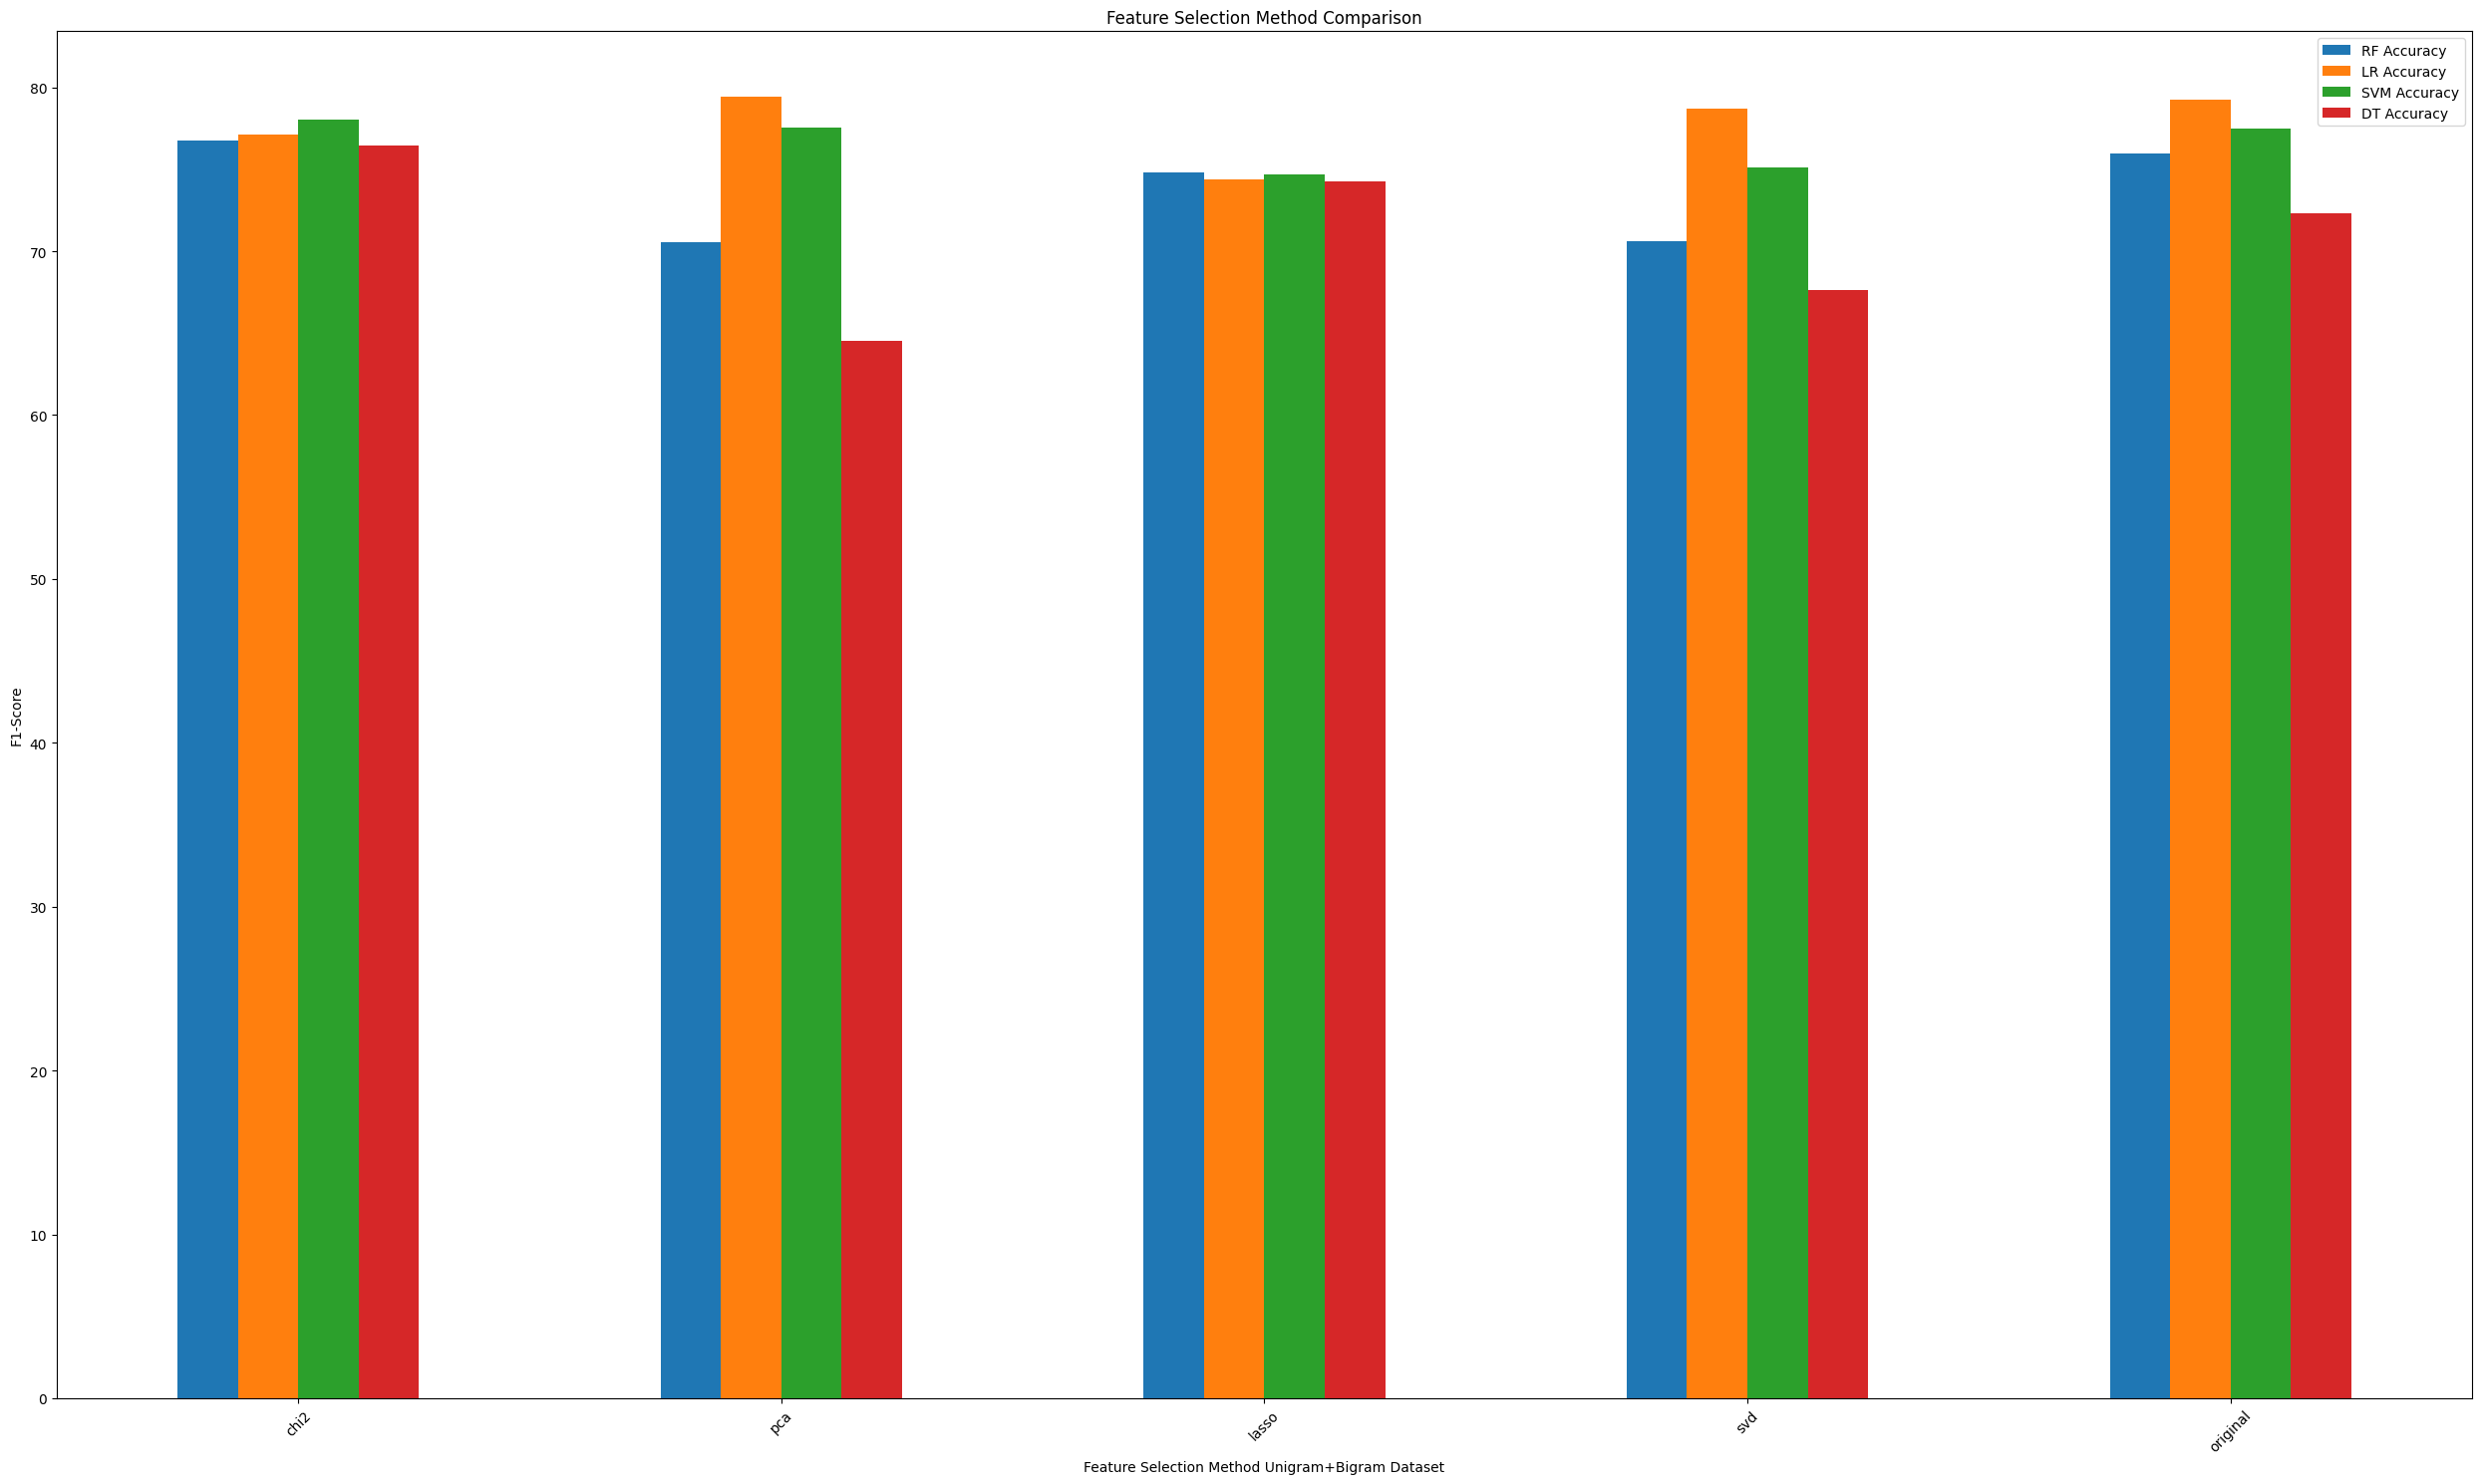

In [ ]:
# Bar chart comparing model accuracies for different feature selection methods
accuracy_df.plot(kind='bar', figsize=(25, 15))
plt.title('Feature Selection Method Comparison')
plt.ylabel('F1-Score')
plt.xlabel('Feature Selection Method Unigram+Bigram Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Process results for different file sizes (100, 500, 1500, 2000)


In [ ]:
with open("results_100.txt","r") as f:
    results = f.read()

results_avg = sum([float(i.split(" ")[-1]) for i in results.split("\n")]) / len(results.split("\n"))
results_avg

In [ ]:
with open("results_500.txt","r") as f:
    results = f.read()

results_avg = sum([float(i.split(" ")[-1]) for i in results.split("\n")]) / len(results.split("\n"))
results_avg

In [ ]:
with open("results.txt","r") as f:
    results = f.read()

results_avg = sum([float(i.split(" ")[-1]) for i in results.split("\n")]) / len(results.split("\n"))
results_avg

In [ ]:
with open("results_1500.txt","r") as f:
    results = f.read()

results_avg = sum([float(i.split(" ")[-1]) for i in results.split("\n")]) / len(results.split("\n"))
results_avg

In [ ]:
with open("results_2000.txt","r") as f:
    results = f.read()

results_avg = sum([float(i.split(" ")[-1]) for i in results.split("\n")]) / len(results.split("\n"))
results_avg